In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

# Introduction

The aim of this notebook is to:

1) Generate a clean daily data matrix including potential features of use in predicting lake chemistry and ecology in Lake Vansjø. Data is read in for the River Hobøl and Lake Vansjø in the Morsa vannområde. Data includes meteorological data, NVE discharge data, river chemistry data and lake chemistry and ecology data for the period ca. 1980-2018. Data is cleaned and aligned.

2) Resample to seasonal, and calculate associated seasonally-aggregated potential explanatory features (e.g. lags, winter sums)

# User input

In [2]:
# User input
# Which Vansjø basin? Van1 (Storefjorden), Van2 (Vanemfjorden)
basin = 'Van2'

# Include TP flux estimates in the data matrix?
inc_fluxes = 0 # 0 or 1

# Include features from Van1 in Van2's features? Only relevant if basin is Van2
inc_Van1 = 0

# FILE PATHS to input data

# Met (T, pptn, wind)
met_source = 'metno' # Choose one of: 'metno', 'era5'
met_fpath_dict = {'metno': r'../../Data/Meteorological/Obs_metno/Obs_Metno_1km_gridded_Morsa_v2.csv',
                  'era5': r'../../Data/Meteorological/06_era5/era5_morsa_1980-2019_daily.csv'}
if met_source == 'metno': # Wind is in a separate file
    wind_fpath = r'../../Data/Meteorological/Obs_metno/Obs_Rygge_MeanWindSpeed.csv' # Mean daily wind speed (m/s), Rygge airport

# PET
PET_fpath = r'../Data/ExploratoryInput/Morsa_ThornthwaitePET.csv' #N.B. calculated using met station temp rather than gridded. But the two are v. comparable (not so pptn)

# Discharge
Q_fpath = r'../../Data/Discharge/3-22-0_D6pm_Hogfoss_Scaled_to_Kure.csv'

# Catchment water quality (at Kure)
catchwq_fpath = r'../../Data/Observed_Chem_Ecol/003-59191_Hobølelva_Kure_chem_obs.csv'

# Lake water quality
lakewq_fpath_dict = {'Van1': r'../Data/ExploratoryInput/Van1_Storefjorden_chem_obs_to2017.csv',
                     'Van2': r'../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_chem_obs.csv'}

# Alternative lake colour data (from Storefjorden, 20m depth, MOVAR data)
movar_color_fpath = r'../../Data/Observed_Chem_Ecol/LakeColour_MOVAR.csv'

# Lake ecology (PTI, biovolume, cyanomax, cyano biovolume)
ecol_fpath_dict = {'Van1': r'../Data/ExploratoryInput/Van1_PTI_Cyano_to2018.xlsx',
                   'Van2':  r'../../Data/Observed_Chem_Ecol/Van2_Vanemfjorden_Cyanobacteria.csv'}

# Output folders
out_file = r'../Data/DataMatrices'
graph_outfolder = r'../Figures'

# Daily data

## Read in daily data

In [3]:
met_fpath = met_fpath_dict[met_source]
met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
if met_source=='metno':
    wind_df = pd.read_csv(wind_fpath, index_col=0, parse_dates=True, dayfirst=True)

pet_df = pd.read_csv(PET_fpath, index_col=0, parse_dates=True, dayfirst=True)
Q_df = pd.read_csv(Q_fpath, index_col=0, parse_dates=True, dayfirst=True)

catchwq_df = pd.read_csv(catchwq_fpath, index_col=0, parse_dates=True, dayfirst=True)

lakewq_df = pd.read_csv(lakewq_fpath_dict[basin], index_col=0, parse_dates=True, dayfirst=True)
color_df = pd.read_csv(movar_color_fpath, index_col=0, parse_dates=True, dayfirst=True)

# If looking at Van2 (Vanemfjorden), also read in lake data from Storefjorden
if basin =='Van2' and inc_Van1==1:
    lakewq_df_van1 = pd.read_csv(lakewq_fpath_dict['Van1'], index_col=0, parse_dates=True, dayfirst=True)

# Read in ecol data from excel sheet one sheet at a time, then merge
if basin=='Van1':
    # Haven't updated Van1 beyond 2018
    ecol_fpath = ecol_fpath_dict['Van1']
    PTI_df = pd.read_excel(ecol_fpath, sheet_name=0, index_col=3, parse_dates=True)
    biovol_df = pd.read_excel(ecol_fpath, sheet_name=1, index_col=3, parse_dates=True)
    cyanoBiovol_df = pd.read_excel(ecol_fpath, sheet_name=2, index_col=0, parse_dates=True)
    ecol_df = pd.concat([PTI_df['PTI'], biovol_df['Biovolume_mm3_per_l'], cyanoBiovol_df['Cyano_biovol_mm3_per_l']], axis=1)
else:
    # For Van2, haven't updated PTI or biovolume data to 2019, only cyanobiovol
    ecol_fpath = ecol_fpath_dict['Van2']
    ecol_df = pd.read_csv(ecol_fpath, index_col=0, parse_dates=True, dayfirst=True)
    # convert units to mm3/l (mg/l if assume density is same as water)
    ecol_df['Cyano_biovol_mm3_per_l'] = ecol_df['Cyano_biovol_mm3_per_m3']/1000.
    ecol_df.drop(['Cyano_biovol_mm3_per_m3'], axis=1, inplace=True)

## Data cleaning and reorganising

### Extract cols of interest from met and Q dfs

In [4]:
# MET DATA

# For the met data, just pick the columns of interest and rename them

if met_source=='metno':
    met_df = met_df[['RR_catch','TG_catch']] # For now, pick rainfall and temp averaged over whole catchment, not just the lake
    met_df.columns = ['Pptn','Temp']
    met_df.index.name = 'Date'
    met_df.index = met_df.index.normalize() # Drop time info from metdf index
    # Add mean daily wind speed (m/s)
    met_df['Wind_speed'] = wind_df.iloc[:,0]

else:
    met_df['Wind_speed'] = np.sqrt((met_df['uas']**2) + (met_df['vas']**2))
    met_df = met_df[['tp','tas','Wind_speed']]
    met_df.columns = ['Pptn','Temp','Wind_speed']
    met_df.index.name = 'Date'

# Remove some dodgy-looking values
met_df.loc[met_df['Pptn']<0.,'Pptn'] = 0.

# Also add PET (mm/day)
met_df['PET'] = pet_df['PET']

met_df.head()

,Pptn,Temp,Wind_speed,PET
Date,,,,
1970-12-31,0.000000,-9.243695,4.6,NaN
1971-01-01,0.000000,-10.881015,0.2,0.0
1971-01-02,0.000000,-9.843024,0.3,0.0
1971-01-03,0.000000,-2.851721,6.0,0.0
1971-01-04,0.000096,-2.219738,2.2,0.0


In [5]:
# Q DATA
Q_df = Q_df['Q_18H_average_m3s_scaled']
Q_df.rename('Q', inplace=True)

Date
1976-09-23    0.089
1976-09-24    0.089
1976-09-25    0.089
1976-09-26    0.090
1976-09-27    0.088
              ...  
2018-09-25    0.392
2018-09-26    0.360
2018-09-27    0.399
2018-09-28    0.424
2018-09-29    0.370
Name: Q, Length: 11702, dtype: float64

In [6]:
# Annual mean wind speed
# met_df['Wind_speed'].groupby(met_df.index.year).mean().plot()

### Process lake colour data

In [7]:
# Lake colour data (merge MOVAR and NIVA data). Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
lakewq_df = pd.merge(lakewq_df, color_df, left_index=True, right_index=True, how='outer')

# Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
s0 = lakewq_df.loc[:'1998-12-31','colour']

id1 = lakewq_df['Colour'].first_valid_index()
s1 = lakewq_df['Colour'].loc[id1:]
s1.name = 'colour'

lastidx = lakewq_df.loc['2013-01-01':,'colour'].last_valid_index()
s2 = lakewq_df.loc['2013-01-01':lastidx,'colour']

colour = pd.concat([s0, s1,s2], axis=0).dropna()

# Drop original MOVAR and NIVA colour series, and replace with the patched series
lakewq_df = lakewq_df.drop(['colour','Colour'], axis=1)
lakewq_df = lakewq_df.merge(colour.to_frame(), left_index=True, right_index=True, how='outer')

# Drop some dodgy-looking values
lakewq_df.loc[:'1982-08-01','colour'] = np.NaN
# lakewq_df[lakewq_df[['SS','SS_min']]>25.] = np.NaN

if basin == 'Van2' and inc_Van1==1:
    lakewq_df_van1.loc[:'1982-08-01','colour'] = np.NaN

### Combine data into one df, drop unwanted cols and rows

['Pptn' 'Temp' 'Wind_speed' 'PET' 'Q' 'TP_catch' 'chl-a_lake' 'TP_lake'
 'colour_lake' 'CyanoBiovol']


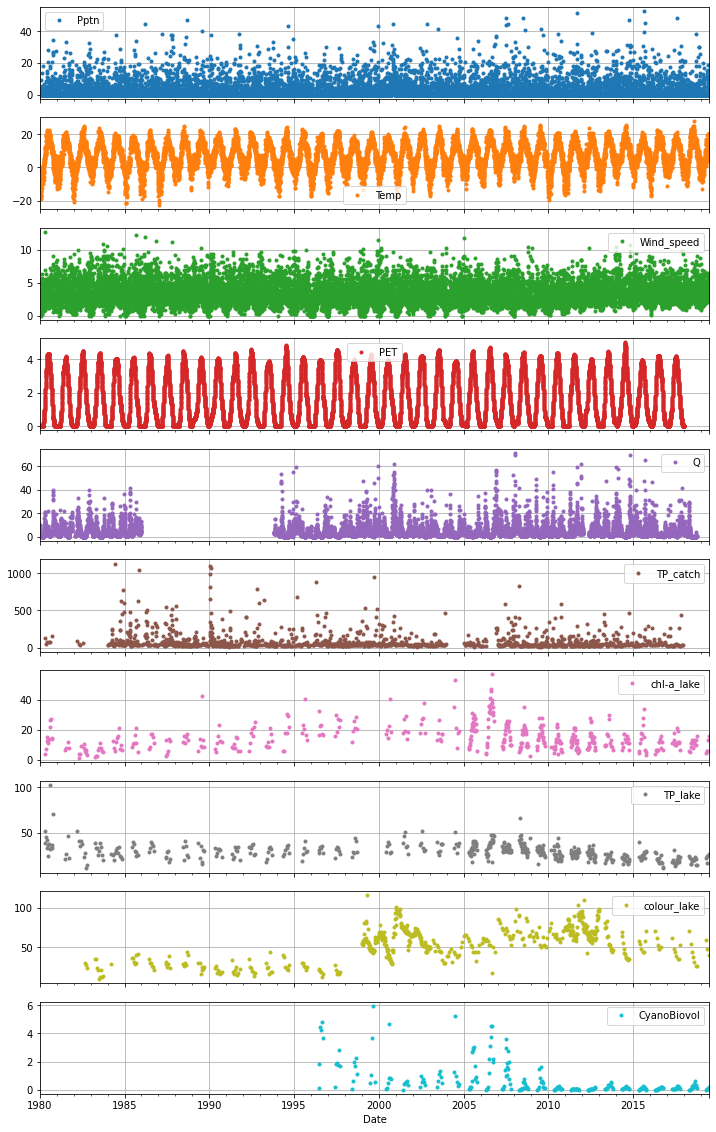

In [8]:
# Add suffixes to lake and water quality columns
catchwq_df = catchwq_df.add_suffix('_catch')
lakewq_df = lakewq_df.add_suffix('_lake')

if basin == 'Van2' and inc_Van1==1:
    lakewq_df_van1 = lakewq_df_van1.add_suffix('_van1')

# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME

if basin == 'Van2' and inc_Van1==1:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df, lakewq_df_van1]
else:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=met_df.index)
    if i<1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc['1980-01-01':,:]

# Drop some cols and rename others
if basin == 'Van2' and inc_Van1==1:
    cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
                    'TDP_lake','SS_lake','SS_min_lake',
                    'TOC_van1', 'TDP_van1', 'SS_min_van1', 'SS_van1',]
else:
    cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch']

var_rename_dict = {'Biovolume_mm3_per_l':'Biovolume','Cyano_biovol_mm3_per_l':'CyanoBiovol'}

daily_df.drop(cols_to_drop, axis=1, inplace=True)
daily_df.rename(var_rename_dict, axis=1, inplace=True)

# Check output
print(daily_df.columns.values)
daily_fig = daily_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3, figsize=(12,20), grid=True);

# plt.savefig(os.path.join(graph_outfolder,'daily_data_tseries_%s.png' %met_source))


### Add precipitation-related features

Add derived variables from daily data.Possible precipitation features, using definitions from the Australian Met service:
1) rain day (boolean of whether it rained that day or not), defined as annual count of days with daily precipitation ≥ 1 mm (to filter out small errors in values under 1 mm).
2) Heavy precipitation days: Annual count of days with daily precipitation ≥ 10 mm

                Pptn  Rain_day
Date                          
1980-01-01  0.000000         0
1980-01-02  0.000000         0
1980-01-03  0.000000         0
1980-01-04  2.669136         1
1980-01-05  2.806878         1
8.499137083600006
                Pptn  Pptn_intense
Date                              
1980-01-01  0.000000             0
1980-01-02  0.000000             0
1980-01-03  0.000000             0
1980-01-04  2.669136             0
1980-01-05  2.806878             0


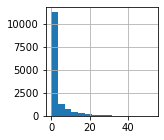

In [9]:
# 1) Rain days
def rain_day(pptn):
    if pptn>1: return 1
    else: return 0
daily_df['Rain_day'] = daily_df['Pptn'].map(rain_day)
print(daily_df[['Pptn','Rain_day']].head())

# 2) Intense rain days: Boolean saying whether precipitation is above a certain threshold
# First, take a look at the distribution of rainfall to decide on the threshold
daily_df['Pptn'].hist(bins=15, figsize=(2,2))
print(daily_df['Pptn'].quantile(q=0.90))

# Decide to go again with AU definition of 'Heavy precipitation days'
def rain_intense(pptn):
    if pptn>10.0: return 1
    else: return 0
daily_df['Pptn_intense'] = daily_df['Pptn'].map(rain_intense)
print(daily_df[['Pptn','Pptn_intense']].head())

### Add wind speed-related features

Nothing wind-related really came out as important in the monthly analysis. So here, cut down on the number of wind-related features to include. Also just add in mean seasonal wind speed.

Median daily wind speed is 3.3 m/s, and the distribution is somewhat right skewed. The main thing that is likely to be important for cyanobacteria is a stable upper water column, so that turbulence doesn't cause cells to sink. The duration of the stable upper water column could also be important, so features could be e.g. x days below whatever wind speed threshold is required for a stable upper water column, AND no (potentially short-lived) periods where the water column is mixed due to high winds.

Q0.2: 2.0 m/s
Q0.4: 2.9 m/s


Q0.6: 3.8 m/s
Q0.8: 4.8 m/s
            Wind_speed  Wind_under_Q0.2  Wind_over_Q0.6
Date                                                   
1980-01-01         2.9            False           False
1980-01-02         3.1            False           False
1980-01-03         1.5             True           False
1980-01-04         1.7             True           False
1980-01-05         1.5             True           False


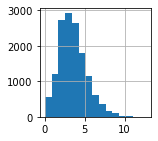

In [10]:
# Wind features: Boolean saying whether wind speed was above or below a certain threshold

# Distribution of wind speed
daily_df['Wind_speed'].hist(bins=15, figsize=(2,2))

# Define 'calm day' features
calm_quantiles = [0.2, 0.4] 
for quantile in calm_quantiles:
    upper_threshold = daily_df['Wind_speed'].quantile(quantile)
    print('Q%s: %s m/s' %(quantile, upper_threshold))
    daily_df['Wind_under_Q%s' %quantile] = daily_df['Wind_speed'] < upper_threshold

print('\n')

# Define 'windy day' features
windy_quantiles = [0.6, 0.8]
for quantile in windy_quantiles:
    lower_threshold = daily_df['Wind_speed'].quantile(quantile)
    print('Q%s: %s m/s' %(quantile, lower_threshold))
    daily_df['Wind_over_Q%s' %quantile] = daily_df['Wind_speed'] > lower_threshold

print (daily_df[['Wind_speed','Wind_under_Q0.2','Wind_over_Q0.6']].head())

### Add temperature-related features

Later in the analysis I was finding that PET was coming out as a significant feature relating to biol. E.g. winter PET correlating with summer cyanobacterial biovolume. I think this could be more about ice thickness and duration, which I can't find long term records for. Instead, lets calculate winter freezing days (days where T<0), and assume the more subzero days the thicker the ice and the longer the ice duration.

In [11]:
daily_df['Temp_subzero'] = daily_df['Temp']<0.
daily_df[['Temp','Temp_subzero']].head()

,Temp,Temp_subzero
Date,,
1980-01-01,-4.758278,True
1980-01-02,-8.821736,True
1980-01-03,-15.280719,True
1980-01-04,-12.965066,True
1980-01-05,-5.304253,True


## Output daily data matrix

In [12]:
# Output to csv
daily_df.to_csv(
    os.path.join(out_file, "Vansjø_daily_data_%s_%s.csv" % (basin, met_source)),
    index_label="Date",
)

In [13]:
os.path.join(out_file, "Vansjø_daily_data_%s_%s.csv" % (basin, met_source))

'../Data/DataMatrices/Vansjø_daily_data_Van2_metno.csv'

# Resample to seasonal

In [14]:
# Set the aggregation method for different variables

vars_to_sum = ["Pptn", "Rain_day", "Pptn_intense", "PET", "Q", "Temp_subzero"]

# Add wind cols to vars to sum
wind_cols = []
for q in calm_quantiles:
    wind_cols.append("Wind_under_Q%s" % q)
for q in windy_quantiles:
    wind_cols.append("Wind_over_Q%s" % q)
vars_to_sum += wind_cols

vars_to_average = [
    "TP_catch",
    "PTI",
    "Temp",
    "Biovolume",
    "rel_res_time",
    "colour_lake",
    "TP_lake",
    "chl-a_lake",
    "Wind_speed",
]

vars_to_max = ["CyanoBiovol"]

if basin == "Van2" and inc_Van1 == 1:
    vars_to_average.extend(["colour_van1", "TP_van1", "chl-a_van1"])

agg_method_dict = {}  # Key: var, returns aggregation method
for var in daily_df.columns:
    if var in vars_to_sum:
        method = np.nansum
    elif var in vars_to_average:
        method = np.nanmean
    elif var in vars_to_max:
        method = np.nanmax
    else:
        method = None
    agg_method_dict[var] = method

# agg_method_dict

For the summer season, you might expect chl-a and cyanobacteria, which have peaks in June-Aug, to show stronger correlations with met variables during these three months, rather than during the full 6 month growing season period. I tried this out, using the code below to calculate just June-Aug seasonal sums/averages, replacing 'daily_df' with 'masked_daily_df' when calculating the seasonal summaries, and then running through the correlations and scatterplots with this different seasonal averaging. But it didn't make any difference, no stronger links between in-lake biol and met variables. Therefore go back to full season summary stats.

In [15]:
# # For summer sesason, met vars perhaps better summed/averaged over just June-Aug when looking
# # for links to algal stuff. Try that.

# # Vars to mask. Met vars. Too fiddly to do others (would need to versions of each then,
# # one used in predicting others, the other the dependent variable, the WFD growing seaason mean)
# peak_summer_vars = vars_to_sum.copy()
# peak_summer_vars.extend(['Temp','Wind_speed'])
# mask_months = [5,9,10] # Summer months to exclude in seasonal aggregation

# masked_daily_df = daily_df.copy()
# masked_daily_df.loc[masked_daily_df.index.month.isin(mask_months), peak_summer_vars] = np.NaN

# masked_daily_df.loc['1991-04-29':'1991-11-01',['Temp','Pptn']]


In [16]:
# RESAMPLE TO SEASONAL

# Define 2 seasons per year. Lake sampling is from mid-April to mid-October, WFD status May-Sep.
# Winter values (e.g. Nov-Dec 1999 & Jan-April 2000) are stored as 2000.

def season(x):
    """Input month number, and return the season it corresponds to
    """
    if x in [11,12,1,2,3,4]:
        return 'wint'
    else:
        return 'summ'

# Resample (enter 'Q' for quarterly, and '-month' for month to end in)
# N.B. if you change season function, need to change this too
season_df = daily_df.resample('2Q-Apr', closed='left').agg(agg_method_dict)
season_df['Season'] = season_df.index.month.map(season)

# Remove frequncy info from index so all plotting works right
season_df.index.freq=None

# Particularly for summed variables, drop 1980 as missing first 2 months
for col in season_df.columns:
    if col in vars_to_sum:
        season_df[col].iloc[0] = np.NaN #Assumes first year is 1980. Index-label based slicing not working annoyingly

# Also drop summer 2019, as have lots of missing data
season_df = season_df.drop([season_df.index[-1]])

# For Q, need to correct the units (summed up m3/s over days, convert to 10^6 m3 per season)
season_df['Q'] = season_df['Q'] * (86400./10**6)

# Summing over seasons gives 0 for Q & PET due to no data. Replace with NaNs
season_df.loc[season_df['Q']==0.0,'Q'] = np.NaN
season_df.loc[season_df['PET']==0.0,'PET'] = np.NaN

season_df

/tmp/ipykernel_11113/2948903126.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_df[col].iloc[0] = np.NaN #Assumes first year is 1980. Index-label based slicing not working annoyingly


,Pptn,Temp,Wind_speed,PET,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,CyanoBiovol,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,Wind_over_Q0.6,Wind_over_Q0.8,Temp_subzero,Season
Date,,,,,,,,,,,,,,,,,,
1980-04-30,NaN,-3.086262,2.848333,NaN,NaN,130.000000,3.971429,45.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wint
1980-10-31,579.570268,13.090170,3.341848,528.944155,87.710170,86.400000,16.080130,43.573016,NaN,NaN,83.0,16.0,33.0,80.0,57.0,27.0,5.0,summ
1981-04-30,244.503965,-0.893721,3.413812,36.989387,69.853277,NaN,NaN,NaN,NaN,NaN,39.0,5.0,41.0,68.0,64.0,38.0,96.0,wint
1981-10-31,494.730157,12.599971,3.488587,515.460389,61.463318,NaN,8.331250,28.833333,NaN,NaN,61.0,17.0,30.0,68.0,68.0,35.0,0.0,summ
1982-04-30,366.125943,-1.877038,3.360221,49.298551,96.428880,69.000000,1.100000,46.250000,NaN,NaN,60.0,10.0,47.0,82.0,69.0,41.0,92.0,wint
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-30,307.789680,1.937102,3.664088,61.733942,61.324560,78.363636,11.000000,17.000000,62.000000,0.018,46.0,12.0,34.0,64.0,71.0,44.0,53.0,wint
2017-10-31,570.221295,13.366517,3.710326,529.270370,67.758768,77.928571,12.866667,19.666667,42.000000,0.258,76.0,20.0,9.0,54.0,75.0,36.0,0.0,summ
2018-04-30,372.847838,0.152024,3.439227,11.259850,105.685949,35.000000,5.500000,24.000000,71.000000,0.002,60.0,10.0,28.0,70.0,57.0,29.0,97.0,wint


## Exploratory boxplots

/tmp/ipykernel_11113/1810285226.py:2: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  bp = season_df.drop(['Temp_subzero'], axis=1).boxplot(by='Season', ax=axs); #For Van1, also drop 'Biovolume' & 'Wind_over_Q0.6'


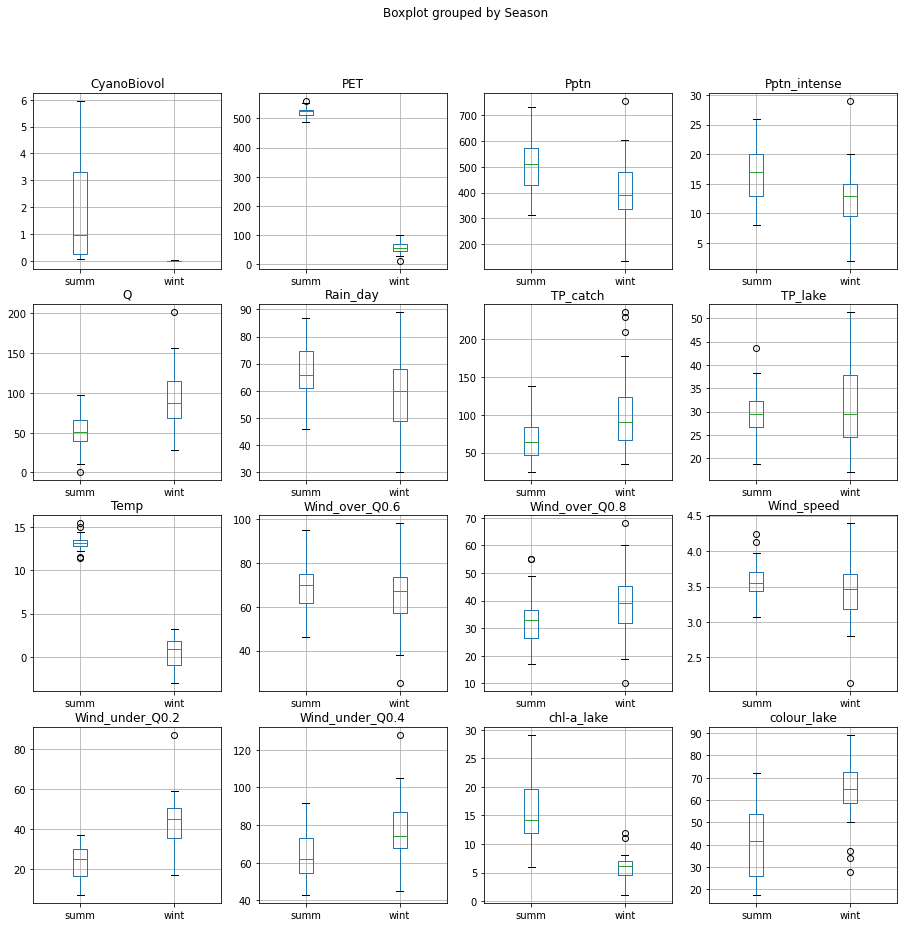

In [17]:
fig, axs = plt.subplots(4,4, sharey=False, figsize=(15,15))
bp = season_df.drop(['Temp_subzero'], axis=1).boxplot(by='Season', ax=axs); #For Van1, also drop 'Biovolume' & 'Wind_over_Q0.6'
[ax.set_xlabel('') for ax in bp];

# plt.savefig(os.path.join(graph_outfolder, 'Season_6M_boxplots_%s.png' %met_source))

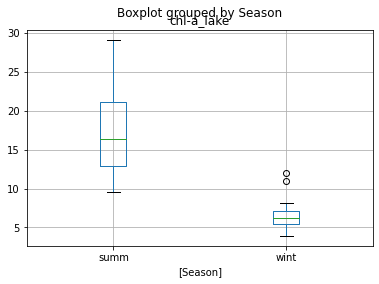

In [18]:
# Zoom in on chl-a, and just for the period where it crosses over with cyanobacteria data

ax = season_df.loc['1997-04-30':,['chl-a_lake','Season']].boxplot(by='Season')

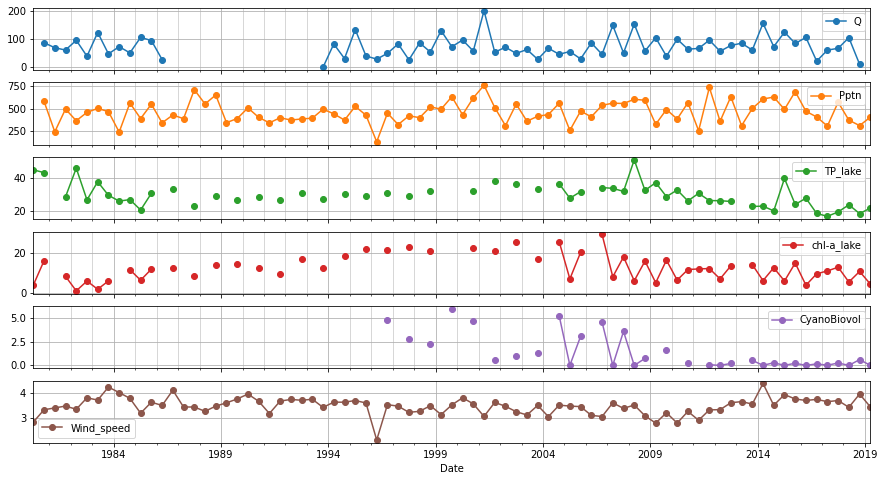

In [19]:
# Time series, to look at winter 2000 flooding event. Can see peak pptn and Q in Nov 2000-Jan 2001.But chl-a was already high before then,
# and cyano if anything decreased for a couple of years after and then went back up again...

ax = season_df.loc[:,['Q','Pptn','TP_lake','chl-a_lake','CyanoBiovol','Wind_speed']].plot(subplots=True, figsize=(15,8), grid=True, marker='o')
ax[0].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[1].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[2].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[3].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[4].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[1].legend(loc='upper right')

## Add lagged variables

In [20]:
# For desired variables, add 1 (and optionally a 2 season) lag

# Only do for variables that we will have data for or may be able to estimate
lag_vars = ['Pptn', 'Temp', 'Wind_speed', 'PET', 'Q',
           'Rain_day', 'Pptn_intense',
           'Wind_under_Q0.2', 'Wind_under_Q0.4', 'Wind_over_Q0.6',
           'Wind_over_Q0.8']

for var in lag_vars:
    season_df['%s_lag1' %var] = season_df[var].shift(+1)
#     season_df['%s_lag2' %var] = season_df[var].shift(+2)


season_df[['Pptn','Pptn_lag1']].head()

,Pptn,Pptn_lag1
Date,,
1980-04-30,NaN,NaN
1980-10-31,579.570268,NaN
1981-04-30,244.503965,579.570268
1981-10-31,494.730157,244.503965
1982-04-30,366.125943,494.730157


In [21]:
# Calculate summer average from previous year. Could define summer as whole WFD growing season (May-Oct, incl.),
# or as just the key summer months (June-Aug/Sep). For now, stick to whole WFD growing season. Explored both and find no difference to results.

prev_summer_toaverage = ['TP_lake', 'colour_lake', 'chl-a_lake', 'Temp','CyanoBiovol'] # Maybe add cyanobacteria here, rather than have as max?

# Filter to just summer and shift
prevSummerCols = season_df.loc[season_df['Season']=='summ',prev_summer_toaverage].shift(+1)
prevSummerCols = prevSummerCols.add_suffix('_prevSummer')
prevSummerCols.head()

season_df = season_df.join(prevSummerCols)

In [22]:
# 'Previous summer' vars are all NaNs for winter season. Fill them backwards
season_df[prevSummerCols.columns] = season_df[prevSummerCols.columns].fillna(method='bfill', axis=0, limit=1)

season_df.loc['2016':'2018',['TP_lake','TP_lake_prevSummer','Temp', 'Temp_prevSummer']]

,TP_lake,TP_lake_prevSummer,Temp,Temp_prevSummer
Date,,,,
2016-04-30,28.000000,24.250000,1.789752,12.687234
2016-10-31,18.750000,24.250000,14.026004,12.687234
2017-04-30,17.000000,18.750000,1.937102,14.026004
2017-10-31,19.666667,18.750000,13.366517,14.026004
2018-04-30,24.000000,19.666667,0.152024,13.366517
2018-10-31,18.666667,19.666667,15.453903,13.366517


In [23]:
season_df.columns

Index(['Pptn', 'Temp', 'Wind_speed', 'PET', 'Q', 'TP_catch', 'chl-a_lake',
       'TP_lake', 'colour_lake', 'CyanoBiovol', 'Rain_day', 'Pptn_intense',
       'Wind_under_Q0.2', 'Wind_under_Q0.4', 'Wind_over_Q0.6',
       'Wind_over_Q0.8', 'Temp_subzero', 'Season', 'Pptn_lag1', 'Temp_lag1',
       'Wind_speed_lag1', 'PET_lag1', 'Q_lag1', 'Rain_day_lag1',
       'Pptn_intense_lag1', 'Wind_under_Q0.2_lag1', 'Wind_under_Q0.4_lag1',
       'Wind_over_Q0.6_lag1', 'Wind_over_Q0.8_lag1', 'TP_lake_prevSummer',
       'colour_lake_prevSummer', 'chl-a_lake_prevSummer', 'Temp_prevSummer',
       'CyanoBiovol_prevSummer'],
      dtype='object')

## Output seasonal data matrix with all data

In [24]:
season_df.to_csv(
    os.path.join(
        out_file,
        "Seasonal_allVars",
        "Vansjø_seasonal_data_1Season_%s_%s.csv" % (basin, met_source),
    )
)

In [26]:
os.path.join(
        out_file,
        "Seasonal_allVars",
        "Vansjø_seasonal_data_1Season_%s_%s.csv" % (basin, met_source))

'../Data/DataMatrices/Seasonal_allVars/Vansjø_seasonal_data_1Season_Van2_metno.csv'